In [ ]:
!pip install pyyaml
!pip install tabulate

In [ ]:
# ## **Bloque 1: Instalación e importación de librerías**
import yaml
from google.colab import drive
import os
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [ ]:
# ## **Bloque 2: Montar Google Drive**
drive.mount('/content/drive')
print("\n¡Drive montado correctamente! 🚀\n")

Mounted at /content/drive

¡Drive montado correctamente! 🚀



In [ ]:
# ## **Bloque 3: Configuración**
class Config:
    EXPECTED_SPLITS = ['train', 'val', 'test']
    IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp'}
    REPORT_FILE = 'dataset_people_report.txt'
    PLOT_SIZE = (15, 8)
    CLASS_NAME = 'person'  # Clase esperada (clase 0)

# ## **Bloque 4: Función para cargar configuración YAML**
def load_yaml_config(base_path):
    yaml_path = base_path / 'data.yaml'
    if yaml_path.exists():
        with open(yaml_path) as f:
            return yaml.safe_load(f)
    return None

# ## **Bloque 5: Función de validación de estructura**
def validate_structure(base_path):
    missing = []
    required_dirs = ['images', 'labels']

    for dir in required_dirs:
        if not (base_path/dir).exists():
            missing.append(f"{dir}/")

    for split in Config.EXPECTED_SPLITS:
        if not (base_path/'images'/split).exists():
            missing.append(f"images/{split}/")
        if not (base_path/'labels'/split).exists():
            missing.append(f"labels/{split}/")

    if missing:
        print("\n⚠️ **Advertencia:** Directorios faltantes:")
        for item in missing:
            print(f"- {item}")
        print("\nEl análisis podría ser incompleto.\n")
        return False
    return True

# ## **Bloque 6: Función de validación de bounding boxes**
def validate_bbox(bbox):
    if len(bbox) != 5:
        return False, "Formato incorrecto (deben ser 5 valores)"

    try:
        class_id, x_center, y_center, width, height = map(float, bbox)
        if class_id != 0:
            return False, f"Class ID inválido: {class_id} (debe ser 0)"

        for val in [x_center, y_center, width, height]:
            if not (0 <= val <= 1):
                return False, f"Valor fuera de rango: {val} (debe estar entre 0-1)"

        return True, ""
    except ValueError:
        return False, "Valores no numéricos"

# ## **Bloque 7: Función de análisis del dataset**
def analyze_dataset(base_path):
    stats = {split: {
        'images': 0,
        'labels': 0,
        'missing_labels': [],
        'missing_images': [],
        'invalid_bboxes': [],
        'total_bboxes': 0,
        'class_distribution': defaultdict(int)
    } for split in Config.EXPECTED_SPLITS}

    for split in Config.EXPECTED_SPLITS:
        # Rutas de imágenes y labels
        img_dir = base_path / 'images' / split
        label_dir = base_path / 'labels' / split

        # Procesar imágenes
        images = list(img_dir.glob('*'))
        images = [f for f in images if f.suffix.lower() in Config.IMAGE_EXTENSIONS]
        stats[split]['images'] = len(images)

        # Procesar labels
        labels = list(label_dir.glob('*.txt'))
        stats[split]['labels'] = len(labels)

        # Verificar correspondencia
        for img in images:
            label_path = label_dir / (img.stem + '.txt')
            if not label_path.exists():
                stats[split]['missing_labels'].append(img.name)

        for lbl in labels:
            img_path = img_dir / (lbl.stem + '.jpg')
            if not img_path.exists():
                img_path = img_dir / (lbl.stem + '.png')
            if not img_path.exists():
                stats[split]['missing_images'].append(lbl.name)

        # Validar bounding boxes
        for lbl_file in tqdm(labels, desc=f"Validando {split}", unit="file"):
            try:
                with open(lbl_file) as f:
                    lines = f.readlines()

                for line_num, line in enumerate(lines, 1):
                    line = line.strip()
                    if not line:
                        continue

                    bbox = line.split()
                    is_valid, error = validate_bbox(bbox)
                    stats[split]['total_bboxes'] += 1
                    stats[split]['class_distribution'][int(bbox[0])] += 1

                    if not is_valid:
                        stats[split]['invalid_bboxes'].append({
                            'file': lbl_file.name,
                            'line': line_num,
                            'error': error,
                            'content': line
                        })
            except Exception as e:
                stats[split]['invalid_bboxes'].append({
                    'file': lbl_file.name,
                    'error': f"Error de lectura: {str(e)}"
                })

    return stats

# ## **Bloque 8: Función de generación de reporte**
def generate_report(stats, base_path):
    report = []
    report.append(f"# 📊 Reporte de Dataset de Detección de Personas\n")
    report.append(f"**Ruta del dataset:** `{base_path}`\n")

    # Resumen general
    report.append("## 📌 Resumen General")
    summary_data = []
    for split in Config.EXPECTED_SPLITS:
        summary_data.append({
            'Split': split.upper(),
            'Imágenes': stats[split]['images'],
            'Etiquetas': stats[split]['labels'],
            'BBoxes Válidos': stats[split]['total_bboxes'],
            'Labels Faltantes': len(stats[split]['missing_labels']),
            'Imágenes Faltantes': len(stats[split]['missing_images']),
            'BBoxes Inválidos': len(stats[split]['invalid_bboxes'])
        })

    df_summary = pd.DataFrame(summary_data)
    report.append(df_summary.to_markdown(index=False))

    # Problemas detectados
    report.append("\n## ❌ Problemas Detectados")
    for split in Config.EXPECTED_SPLITS:
        report.append(f"\n### {split.upper()}:")
        if stats[split]['missing_labels']:
            report.append(f"- Imágenes sin labels: {len(stats[split]['missing_labels'])}")
        if stats[split]['missing_images']:
            report.append(f"- Labels sin imágenes: {len(stats[split]['missing_images'])}")
        if stats[split]['invalid_bboxes']:
            report.append(f"- Bounding boxes inválidos: {len(stats[split]['invalid_bboxes'])}")

    # Ejemplos de errores
    report.append("\n## 🚨 Ejemplos de Errores")
    for split in Config.EXPECTED_SPLITS:
        if stats[split]['invalid_bboxes']:
            report.append(f"\n### {split.upper()} - Primeros 3 errores:")
            for error in stats[split]['invalid_bboxes'][:3]:
                report.append(f"- **{error['file']}** (Línea {error.get('line', '?')}):")
                report.append(f"  `{error.get('content', '')}`")
                report.append(f"  Error: {error['error']}")

    return '\n'.join(report)

# ## **Bloque 9: Visualización de datos**
def visualize_stats(stats):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Gráfico 1: Distribución de imágenes
    splits = Config.EXPECTED_SPLITS
    image_counts = [stats[s]['images'] for s in splits]
    axes[0,0].bar(splits, image_counts)
    axes[0,0].set_title('Distribución de Imágenes por Split')

    # Gráfico 2: Bounding boxes por split
    bbox_counts = [stats[s]['total_bboxes'] for s in splits]
    axes[0,1].pie(bbox_counts, labels=splits, autopct='%1.1f%%')
    axes[0,1].set_title('Distribución de Bounding Boxes')

    # Gráfico 3: Distribución de clases
    class_counts = [stats[s]['class_distribution'].get(0, 0) for s in splits]
    axes[1,0].bar(splits, class_counts)
    axes[1,0].set_title('Detecciones de Personas (Clase 0)')

    # Gráfico 4: Problemas por split
    problems = {
        'Missing Labels': [len(stats[s]['missing_labels']) for s in splits],
        'Invalid BBoxes': [len(stats[s]['invalid_bboxes']) for s in splits]
    }
    df_problems = pd.DataFrame(problems, index=splits)
    df_problems.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Problemas Detectados por Split')

    plt.tight_layout()
    plt.show()


Validando test: 100%|██████████| 800/800 [00:03<00:00, 215.83file/s]



# 📊 Reporte de Dataset de Detección de Personas

**Ruta del dataset:** `/content/drive/MyDrive/Proyecto IA-3/violence_school_project/dataset_people`

## 📌 Resumen General
| Split   |   Imágenes |   Etiquetas |   BBoxes Válidos |   Labels Faltantes |   Imágenes Faltantes |   BBoxes Inválidos |
|:--------|-----------:|------------:|-----------------:|-------------------:|---------------------:|-------------------:|
| TRAIN   |       5600 |        5600 |            14161 |                  0 |                    0 |                  0 |
| VAL     |       1600 |        1600 |             4251 |                  0 |                    0 |                  0 |
| TEST    |        800 |         800 |             2113 |                  0 |                    0 |                  0 |

## ❌ Problemas Detectados

### TRAIN:

### VAL:

### TEST:

## 🚨 Ejemplos de Errores


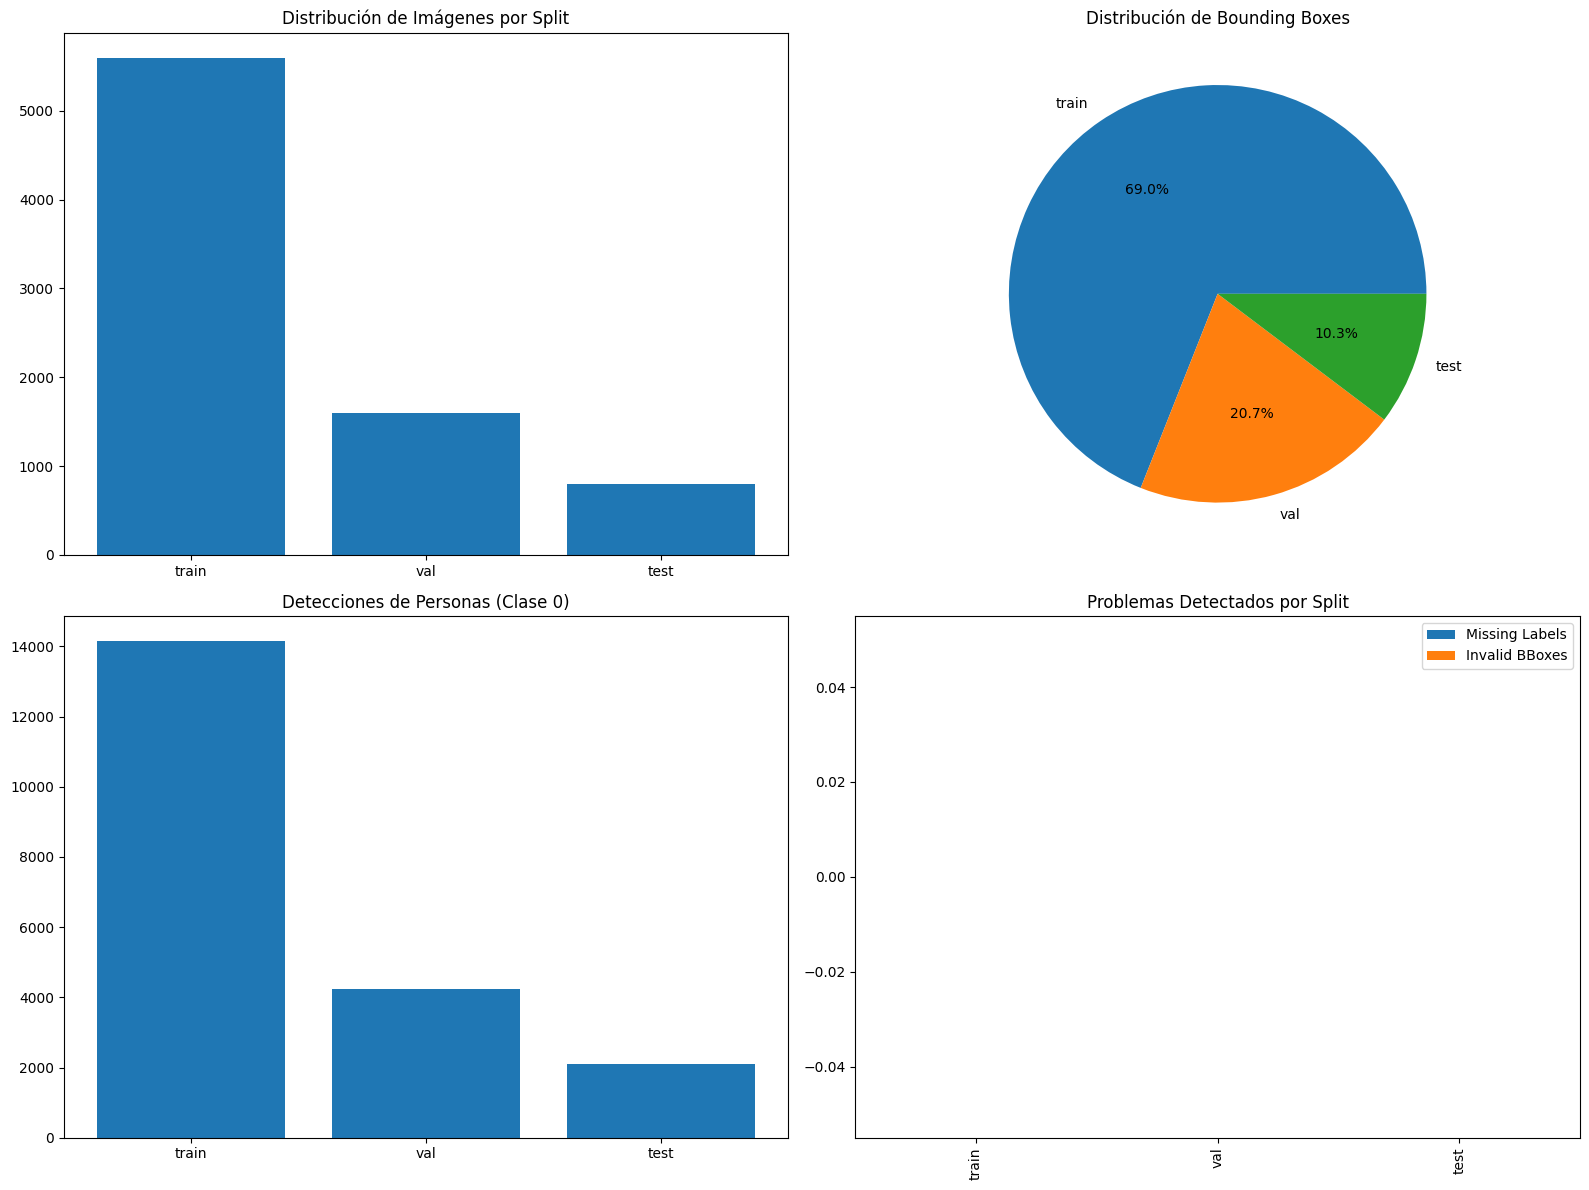


✅ Reporte guardado como: dataset_people_report.txt


In [ ]:
# ## **Bloque 10: Ejecución principal**
# Obtener ruta del dataset
base_path = Path('/content/drive/MyDrive/Proyecto IA-3/violence_school_project/dataset_people')

# Validar estructura
if not validate_structure(base_path):
    raise SystemExit("Error en la estructura del dataset")

# Analizar dataset
stats = analyze_dataset(base_path)

# Generar y mostrar reporte
report = generate_report(stats, base_path)
print("\n" + report)

# Visualización
visualize_stats(stats)

# Guardar reporte
with open(Config.REPORT_FILE, 'w') as f:
    f.write(report)
print(f"\n✅ Reporte guardado como: {Config.REPORT_FILE}")

In [ ]:
# Ejemplo: Eliminar todos los .npy en val/
import os

# Define the full path to the directory
val_dir_path = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/dataset_people/images/val"

for file in os.listdir(val_dir_path):
    if file.endswith(".npy") or file.endswith(".nyx"):
        # Join the directory path with the filename to get the full file path
        file_path = os.path.join(val_dir_path, file)
        os.remove(file_path)

# **DATA AUMENTATIONS**

In [ ]:
!pip install pyyaml
!pip install tabulate
!pip install albumentations # Install albumentations
!pip install opencv-python # Ensure opencv-python is installed for cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.8/307.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.7 MB/s eta 0:00:00


In [ ]:
# ## **Bloque 1: Instalación e importación de librerías**
import yaml
from google.colab import drive
import os
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import cv2
import albumentations as A
import glob
import shutil
import random


In [ ]:
# Montar Google Drive si aún no está montado
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
    print("Google Drive montado correctamente.")
else:
    print("Google Drive ya está montado.")

Google Drive ya está montado.


In [ ]:
# Configuración de directorios para Google Colab con Drive
DRIVE_BASE = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project"
DATASET_ROOT = f"{DRIVE_BASE}/dataset_people"
OUTPUT_ROOT = f"{DRIVE_BASE}/dataset_people_augmented"  # Aquí se guardarán los datos aumentados

print(f"Ruta del dataset original: {DATASET_ROOT}")
print(f"Ruta donde se guardarán los datos aumentados: {OUTPUT_ROOT}")

# Crear directorios de salida si no existen
for split in ["train", "val", "test"]:
    for subdir in ["images", "labels"]:
        os.makedirs(os.path.join(OUTPUT_ROOT, subdir, split), exist_ok=True)

# Directorio para visualizaciones
VIZ_DIR = os.path.join(OUTPUT_ROOT, "visualizaciones")
os.makedirs(VIZ_DIR, exist_ok=True)


# Comprobar si las rutas existen
for split in ["train", "val", "test"]:
    img_dir = os.path.join(DATASET_ROOT, "images", split)
    label_dir = os.path.join(DATASET_ROOT, "labels", split)

    if os.path.exists(img_dir) and os.path.exists(label_dir):
        print(f"Directorios para {split} encontrados correctamente.")
    else:
        print(f"ADVERTENCIA: Los directorios para {split} no existen: {img_dir} o {label_dir}")


Ruta del dataset original: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/dataset_people
Ruta donde se guardarán los datos aumentados: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/dataset_people_augmented
Directorios para train encontrados correctamente.
Directorios para val encontrados correctamente.
Directorios para test encontrados correctamente.


In [ ]:
# AJUSTES A LAS TRANSFORMACIONES: más realistas para personas

# Transformaciones para entrenamiento
train_transform = A.Compose([
    # Transformaciones geométricas realistas
    A.HorizontalFlip(p=0.5),  # Flip horizontal es realista

    # Eliminamos rotaciones extremas y solo permitimos pequeñas
    # inclinaciones que podrían ser naturales en cámaras
    A.Rotate(limit=5, p=0.3),  # Rotación muy limitada (solo 5 grados máximo)

    # Ajustamos el recorte para ser más realista
    A.OneOf([
        # Conservamos la relación de aspecto
        A.RandomSizedBBoxSafeCrop(height=640, width=640, p=0.3),
        A.Resize(height=640, width=640, p=0.7)
    ], p=1.0),

    # Transformaciones de color/iluminación (realistas para vigilancia)
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.3),
    ], p=0.7),

    # Transformaciones ambientales realistas para escenas de vigilancia
    A.OneOf([
        A.RandomShadow(p=0.3),
        A.RandomFog(fog_coef_lower=0.01, fog_coef_upper=0.1, p=0.1),  # Niebla muy sutil
    ], p=0.3),

    # Ruido realista para cámaras (común en vigilancia)
    A.OneOf([
        A.GaussNoise(var_limit=(5.0, 15.0), p=0.3),  # Ruido sutil
        A.CLAHE(clip_limit=2.0, p=0.3),  # Mejora de contraste realista
        A.ImageCompression(quality_lower=85, quality_upper=100, p=0.3),  # Compresión típica CCTV
        A.GaussianBlur(blur_limit=(1, 2), p=0.2),  # Desenfoque muy leve
    ], p=0.3),
], bbox_params=A.BboxParams(
    format='yolo',  # Formato YOLO [class_id, x_center, y_center, width, height]
    min_area=0.0001,
    min_visibility=0.3,  # Aumentamos para evitar recortes extremos
    label_fields=['class_labels']
))

# Transformaciones más ligeras para validación
val_transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.Resize(height=640, width=640)
], bbox_params=A.BboxParams(
    format='yolo',
    min_area=0.0001,
    min_visibility=0.3,
    label_fields=['class_labels']
))

<ipython-input-29-7c8a7e86a4cd>:28: UserWarning: Argument(s) 'fog_coef_lower, fog_coef_upper' are not valid for transform RandomFog
  A.RandomFog(fog_coef_lower=0.01, fog_coef_upper=0.1, p=0.1),  # Niebla muy sutil
<ipython-input-29-7c8a7e86a4cd>:33: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 15.0), p=0.3),  # Ruido sutil
<ipython-input-29-7c8a7e86a4cd>:35: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=85, quality_upper=100, p=0.3),  # Compresión típica CCTV


In [ ]:
# Definimos exactamente dos transformaciones específicas basadas en las que solicitaste

# Aumentación tipo 1: Flip horizontal con más brillo
transform_type1 = A.Compose([
    A.HorizontalFlip(p=1.0),  # Siempre hacer flip horizontal
    A.RandomBrightnessContrast(brightness_limit=(0.1, 0.2), contrast_limit=0, p=1.0),  # Aumentar brillo
], bbox_params=A.BboxParams(
    format='yolo',
    min_area=0.0001,
    min_visibility=0.3,
    label_fields=['class_labels']
))

# Aumentación tipo 2: Pequeña rotación (como en la imagen 3)
transform_type2 = A.Compose([
    A.Rotate(limit=3, p=1.0),  # Rotación muy sutil, siempre aplicada
], bbox_params=A.BboxParams(
    format='yolo',
    min_area=0.0001,
    min_visibility=0.3,
    label_fields=['class_labels']
))

In [ ]:
def visualize_bbox(img, bboxes, class_ids, class_name="person"):
    """Visualiza la imagen con sus bounding boxes para verificación"""
    img = img.copy()
    h, w, _ = img.shape

    for i, bbox in enumerate(bboxes):
        # Convertir de formato YOLO [x_center, y_center, width, height] a píxeles
        x_center, y_center, width, height = bbox
        x_min = int((x_center - width/2) * w)
        y_min = int((y_center - height/2) * h)
        x_max = int((x_center + width/2) * w)
        y_max = int((y_center + height/2) * h)

        # Dibujar rectángulo
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Etiqueta
        cv2.putText(img, class_name, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    return img

def apply_augmentation(image_path, label_path, output_image_dir, output_label_dir, transform,
                       num_augmentations=3, visualize=False, viz_sample_prob=0.05):
    """Aplica aumentación a una imagen y sus etiquetas"""
    # Leer imagen
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error al leer la imagen: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Leer etiquetas
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
    except Exception as e:
        print(f"Error al leer el archivo de etiquetas {label_path}: {e}")
        return

    bboxes = []
    class_labels = []

    # Procesar etiquetas
    for line in lines:
        try:
            values = line.strip().split()
            class_id = int(values[0])
            x_center, y_center, width, height = [float(x) for x in values[1:5]]

            # Verificar si los valores están en el rango correcto (0-1 para YOLO)
            if not all(0 <= val <= 1 for val in [x_center, y_center, width, height]):
                print(f"Advertencia: Valores fuera de rango en {label_path}: {values}")
                continue

            bboxes.append([x_center, y_center, width, height])
            class_labels.append(class_id)
        except Exception as e:
            print(f"Error al procesar línea en {label_path}: {line} - {e}")
            continue

    # Si no hay cajas válidas, omitir esta imagen
    if not bboxes:
        print(f"No se encontraron bounding boxes válidos en {label_path}")
        return

    # Obtener nombre base del archivo
    base_name = os.path.basename(image_path).split('.')[0]

    # Visualizar imagen original
    if visualize and random.random() < viz_sample_prob:
        vis_img = visualize_bbox(image, bboxes, class_labels)
        plt.figure(figsize=(10, 10))
        plt.imshow(vis_img)
        plt.title("Original Image")
        plt.axis('off')
        plt.savefig(os.path.join(VIZ_DIR, f"{base_name}_original.jpg"), dpi=100)
        plt.close()

    # Crear augmentaciones
    augmentation_attempts = 0
    successful_augmentations = 0

    # Intentaremos más veces para conseguir el número deseado de aumentaciones válidas
    while successful_augmentations < num_augmentations and augmentation_attempts < num_augmentations * 2:
        augmentation_attempts += 1

        try:
            # Aplicar transformación
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)

            aug_image = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_class_labels = augmented['class_labels']

            # Verificar que la aumentación contiene los bounding boxes esperados
            if not aug_bboxes:
                continue

            # Verificar que los bounding boxes no están demasiado distorsionados
            valid_boxes = True
            for bbox in aug_bboxes:
                _, _, w, h = bbox
                # Rechazar si el ancho o alto son demasiado pequeños o grandes
                if w < 0.02 or h < 0.02 or w > 0.95 or h > 0.95:
                    valid_boxes = False
                    break

            if not valid_boxes:
                continue

            # Si llegamos aquí, la aumentación es válida
            successful_augmentations += 1

            # Guardar imagen aumentada
            output_image_path = os.path.join(output_image_dir, f"{base_name}_aug{successful_augmentations}.jpg")
            cv2.imwrite(output_image_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

            # Guardar etiquetas aumentadas
            output_label_path = os.path.join(output_label_dir, f"{base_name}_aug{successful_augmentations}.txt")
            with open(output_label_path, 'w') as f:
                for bbox, class_id in zip(aug_bboxes, aug_class_labels):
                    f.write(f"{class_id} {' '.join([str(x) for x in bbox])}\n")

            # Visualizar aumentaciones
            if visualize and random.random() < viz_sample_prob:
                vis_aug_img = visualize_bbox(aug_image, aug_bboxes, aug_class_labels)
                plt.figure(figsize=(10, 10))
                plt.imshow(vis_aug_img)
                plt.title(f"Augmented Image {successful_augmentations}")
                plt.axis('off')
                plt.savefig(os.path.join(VIZ_DIR, f"{base_name}_aug{successful_augmentations}.jpg"), dpi=100)
                plt.close()

        except Exception as e:
            print(f"Error en la augmentación para {image_path}: {e}")
            continue

def process_split(split_name="train", augmentations_per_image=3, visualize_sample=True, max_images=None):
    """Procesa un conjunto de datos (train/val/test) con opción de limitar imágenes para pruebas"""
    print(f"\n{'='*50}")
    print(f"Procesando split: {split_name}")
    print(f"{'='*50}")

    # Directorios originales
    src_image_dir = os.path.join(DATASET_ROOT, "images", split_name)
    src_label_dir = os.path.join(DATASET_ROOT, "labels", split_name)

    # Directorios de salida
    output_image_dir = os.path.join(OUTPUT_ROOT, "images", split_name)
    output_label_dir = os.path.join(OUTPUT_ROOT, "labels", split_name)

    # Seleccionar transformación según el split
    transform = train_transform if split_name == "train" else val_transform

    # Obtener todas las imágenes
    image_files = glob.glob(os.path.join(src_image_dir, "*.jpg"))
    if not image_files:
        image_files = glob.glob(os.path.join(src_image_dir, "*.png"))

    if not image_files:
        print(f"ADVERTENCIA: No se encontraron imágenes en {src_image_dir}")
        return

    print(f"Encontradas {len(image_files)} imágenes en {src_image_dir}")

    # Limitar el número de imágenes para pruebas si es necesario
    if max_images is not None and max_images > 0 and max_images < len(image_files):
        print(f"Limitando procesamiento a {max_images} imágenes (para pruebas)")
        random.shuffle(image_files)  # Aleatorizamos para tener una muestra representativa
        image_files = image_files[:max_images]

    # Copiar archivos originales primero
    print("Copiando archivos originales...")
    for img_path in tqdm(image_files):
        base_name = os.path.basename(img_path)
        label_name = os.path.splitext(base_name)[0] + ".txt"
        label_path = os.path.join(src_label_dir, label_name)

        if os.path.exists(label_path):
            try:
                shutil.copy(img_path, os.path.join(output_image_dir, base_name))
                shutil.copy(label_path, os.path.join(output_label_dir, label_name))
            except Exception as e:
                print(f"Error al copiar archivos originales: {e}")

    # Aplicar aumentación solo si se requiere
    if augmentations_per_image > 0:
        print(f"Aplicando aumentación ({augmentations_per_image} por imagen)...")
        for img_path in tqdm(image_files):
            base_name = os.path.basename(img_path)
            label_name = os.path.splitext(base_name)[0] + ".txt"
            label_path = os.path.join(src_label_dir, label_name)

            if os.path.exists(label_path):
                apply_augmentation(
                    img_path,
                    label_path,
                    output_image_dir,
                    output_label_dir,
                    transform,
                    num_augmentations=augmentations_per_image,
                    visualize=visualize_sample,
                    viz_sample_prob=0.05  # Visualizamos más para asegurar
                )

def update_yaml_file():
    """Actualiza o crea el archivo data.yaml para el dataset aumentado"""
    src_yaml = os.path.join(DATASET_ROOT, "data.yaml")
    dst_yaml = os.path.join(OUTPUT_ROOT, "data.yaml")

    if os.path.exists(src_yaml):
        # Leer el YAML original
        with open(src_yaml, 'r') as f:
            yaml_content = f.read()

        # Actualizar rutas (para el caso de Drive, mejor usar rutas absolutas)
        updated_content = []
        for line in yaml_content.split('\n'):
            if line.startswith('train:') or line.startswith('val:') or line.startswith('test:'):
                key = line.split(':')[0].strip()
                updated_content.append(f"{key}: {os.path.join(OUTPUT_ROOT, 'images', key)}")
            else:
                updated_content.append(line)

        yaml_content = '\n'.join(updated_content)

        # Guardar nuevo YAML
        with open(dst_yaml, 'w') as f:
            f.write(yaml_content)

        print(f"Archivo data.yaml actualizado en {dst_yaml}")
    else:
        # Crear un YAML básico
        train_path = os.path.join(OUTPUT_ROOT, "images", "train")
        val_path = os.path.join(OUTPUT_ROOT, "images", "val")
        test_path = os.path.join(OUTPUT_ROOT, "images", "test")

        yaml_content = f"""# Dataset configuración para YOLOv11
train: {train_path}
val: {val_path}
test: {test_path}

# Número de clases
nc: 1

# Nombres de clases
names: ['person']
"""

        with open(dst_yaml, 'w') as f:
            f.write(yaml_content)

        print(f"Archivo data.yaml creado en {dst_yaml}")

def print_summary():
    """Imprime un resumen del proceso de aumentación"""
    print("\n\n" + "="*60)
    print("RESUMEN DE AUMENTACIÓN DE DATOS".center(60))
    print("="*60)

    for split in ["train", "val", "test"]:
        img_dir = os.path.join(DATASET_ROOT, "images", split)
        aug_img_dir = os.path.join(OUTPUT_ROOT, "images", split)

        if not os.path.exists(img_dir) or not os.path.exists(aug_img_dir):
            print(f"Split {split.upper()}: Directorio no encontrado, omitiendo...")
            continue

        orig_count = len(glob.glob(os.path.join(img_dir, "*.jpg")))
        if orig_count == 0:
            orig_count = len(glob.glob(os.path.join(img_dir, "*.png")))

        aug_count = len(glob.glob(os.path.join(aug_img_dir, "*.jpg")))
        if aug_count == 0:
            aug_count = len(glob.glob(os.path.join(aug_img_dir, "*.png")))

        if orig_count > 0:
            print(f"Split {split.upper()}:")
            print(f"  - Imágenes originales: {orig_count}")
            print(f"  - Imágenes después de aumentación: {aug_count}")
            print(f"  - Incremento: {aug_count - orig_count} imágenes ({(aug_count/orig_count - 1)*100:.1f}% más)")
            print("-"*60)

    print("\nVisualizaciones guardadas en:", VIZ_DIR)
    print(f"\nDataset aumentado guardado en: {OUTPUT_ROOT}")
    print("="*60)

def test_run_single_image():
    """Ejecuta una prueba en una sola imagen para verificar que todo funciona"""
    print("\nEjecutando prueba en una sola imagen...")

    # Buscar una imagen de prueba
    for split in ["train", "val"]:
        img_dir = os.path.join(DATASET_ROOT, "images", split)
        if os.path.exists(img_dir):
            image_files = glob.glob(os.path.join(img_dir, "*.jpg"))
            if not image_files:
                image_files = glob.glob(os.path.join(img_dir, "*.png"))

            if image_files:
                test_img = image_files[0]
                base_name = os.path.basename(test_img)
                label_name = os.path.splitext(base_name)[0] + ".txt"
                label_path = os.path.join(DATASET_ROOT, "labels", split, label_name)

                if os.path.exists(label_path):
                    print(f"Probando con imagen: {test_img}")
                    output_img_dir = os.path.join(OUTPUT_ROOT, "test_single")
                    output_label_dir = os.path.join(OUTPUT_ROOT, "test_single")
                    os.makedirs(output_img_dir, exist_ok=True)

                    # Aplicar aumentación a esta imagen solamente
                    transform = train_transform
                    apply_augmentation(
                        test_img,
                        label_path,
                        output_img_dir,
                        output_label_dir,
                        transform,
                        num_augmentations=5,  # Generamos 5 para ver variedad
                        visualize=True,
                        viz_sample_prob=1.0  # Siempre visualizar
                    )

                    print(f"Prueba completada. Verifica el directorio: {output_img_dir}")
                    return True

    print("No se pudo encontrar una imagen de prueba válida.")
    return False

In [ ]:
# Ejecutar el proceso completo
if __name__ == "__main__":
    # OPCIÓN RECOMENDADA:
    # Primero hacer una prueba con una sola imagen para verificar transformaciones
    test_run_single_image()

    # Después, ejecutar el proceso completo
    # process_split("train", augmentations_per_image=5)  # 5 aumentaciones por imagen para train
    # process_split("val", augmentations_per_image=2)    # 2 aumentaciones por imagen para val
    # No aumentamos test para mantenerlo como referencia de evaluación

    # Actualizar el archivo YAML
    update_yaml_file()

    # Imprimir resumen
    print_summary()

    print("\n¡Proceso completado! Los datos aumentados están disponibles en Google Drive.")


Ejecutando prueba en una sola imagen...
Probando con imagen: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/dataset_people/images/train/people_3721.jpg
Prueba completada. Verifica el directorio: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/dataset_people_augmented/test_single
Archivo data.yaml actualizado en /content/drive/MyDrive/Proyecto IA-3/violence_school_project/dataset_people_augmented/data.yaml


              RESUMEN DE AUMENTACIÓN DE DATOS               
Split TRAIN:
  - Imágenes originales: 5600
  - Imágenes después de aumentación: 0
  - Incremento: -5600 imágenes (-100.0% más)
------------------------------------------------------------
Split VAL:
  - Imágenes originales: 1600
  - Imágenes después de aumentación: 0
  - Incremento: -1600 imágenes (-100.0% más)
------------------------------------------------------------
Split TEST:
  - Imágenes originales: 800
  - Imágenes después de aumentación: 0
  - Incremento: -800 imágenes (-100.0% más)
--

In [ ]:
def visualize_bbox(img, bboxes, class_ids, class_name="person"):
    """Visualiza la imagen con sus bounding boxes para verificación"""
    img = img.copy()
    h, w, _ = img.shape

    for i, bbox in enumerate(bboxes):
        # Convertir de formato YOLO [x_center, y_center, width, height] a píxeles
        x_center, y_center, width, height = bbox
        x_min = int((x_center - width/2) * w)
        y_min = int((y_center - height/2) * h)
        x_max = int((x_center + width/2) * w)
        y_max = int((y_center + height/2) * h)

        # Dibujar rectángulo
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Etiqueta
        cv2.putText(img, class_name, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    return img

def apply_augmentation_type(image_path, label_path, output_image_dir, output_label_dir,
                            transform_type, aug_name, visualize=False):
    """Aplica un tipo específico de transformación a una imagen"""
    # Leer imagen
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error al leer la imagen: {image_path}")
        return False

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Leer etiquetas
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
    except Exception as e:
        print(f"Error al leer el archivo de etiquetas {label_path}: {e}")
        return False

    bboxes = []
    class_labels = []

    # Procesar etiquetas
    for line in lines:
        try:
            values = line.strip().split()
            class_id = int(values[0])
            x_center, y_center, width, height = [float(x) for x in values[1:5]]

            # Verificar si los valores están en el rango correcto (0-1 para YOLO)
            if not all(0 <= val <= 1 for val in [x_center, y_center, width, height]):
                print(f"Advertencia: Valores fuera de rango en {label_path}: {values}")
                continue

            bboxes.append([x_center, y_center, width, height])
            class_labels.append(class_id)
        except Exception as e:
            print(f"Error al procesar línea en {label_path}: {line} - {e}")
            continue

    # Si no hay cajas válidas, omitir esta imagen
    if not bboxes:
        print(f"No se encontraron bounding boxes válidos en {label_path}")
        return False

    # Obtener nombre base del archivo
    base_name = os.path.basename(image_path).split('.')[0]

    try:
        # Aplicar transformación
        augmented = transform_type(image=image, bboxes=bboxes, class_labels=class_labels)

        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_class_labels = augmented['class_labels']

        # Verificar que la aumentación contiene los bounding boxes esperados
        if not aug_bboxes:
            print(f"La transformación {aug_name} eliminó todos los bounding boxes para {image_path}, omitiendo.")
            return False

        # Guardar imagen aumentada
        output_image_path = os.path.join(output_image_dir, f"{base_name}_aug_{aug_name}.jpg")
        cv2.imwrite(output_image_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

        # Guardar etiquetas aumentadas
        output_label_path = os.path.join(output_label_dir, f"{base_name}_aug_{aug_name}.txt")
        with open(output_label_path, 'w') as f:
            for bbox, class_id in zip(aug_bboxes, aug_class_labels):
                f.write(f"{class_id} {' '.join([str(x) for x in bbox])}\n")

        # Visualizar aumentación si se solicita
        if visualize:
            vis_aug_img = visualize_bbox(aug_image, aug_bboxes, aug_class_labels)
            plt.figure(figsize=(10, 10))
            plt.imshow(vis_aug_img)
            plt.title(f"Augmented Image - {aug_name}")
            plt.axis('off')
            plt.savefig(os.path.join(VIZ_DIR, f"{base_name}_aug_{aug_name}.jpg"), dpi=100)
            plt.close()

        return True  # La aumentación se realizó correctamente

    except Exception as e:
        print(f"Error en la aumentación {aug_name} para {image_path}: {e}")
        return False

def process_limited_split(split_name, total_images, visualize_sample=True):
    """
    Procesa una cantidad limitada de imágenes para cada tipo de aumentación.
    Garantiza que no se procese la misma imagen dos veces.

    Args:
        split_name: Nombre del split ('train' o 'val')
        total_images: Número total de imágenes a procesar (se dividirá entre los 2 tipos)
        visualize_sample: Si se deben visualizar algunas muestras
    """
    print(f"\n{'='*50}")
    print(f"Procesando split {split_name} con {total_images} imágenes totales")
    print(f"{'='*50}")

    # Directorios originales
    src_image_dir = os.path.join(DATASET_ROOT, "images", split_name)
    src_label_dir = os.path.join(DATASET_ROOT, "labels", split_name)

    # Directorios de salida
    output_image_dir = os.path.join(OUTPUT_ROOT, "images", split_name)
    output_label_dir = os.path.join(OUTPUT_ROOT, "labels", split_name)

    # Obtener todas las imágenes
    image_files = glob.glob(os.path.join(src_image_dir, "*.jpg"))
    if not image_files:
        image_files = glob.glob(os.path.join(src_image_dir, "*.png"))

    if not image_files:
        print(f"ADVERTENCIA: No se encontraron imágenes en {src_image_dir}")
        return

    print(f"Encontradas {len(image_files)} imágenes en {src_image_dir}")

    # Copiar archivos originales primero
    print("Copiando archivos originales...")
    valid_image_files = []  # Almacenar solo imágenes con etiquetas válidas

    for img_path in tqdm(image_files):
        base_name = os.path.basename(img_path)
        label_name = os.path.splitext(base_name)[0] + ".txt"
        label_path = os.path.join(src_label_dir, label_name)

        if os.path.exists(label_path):
            try:
                shutil.copy(img_path, os.path.join(output_image_dir, base_name))
                shutil.copy(label_path, os.path.join(output_label_dir, label_name))
                valid_image_files.append(img_path)  # Añadir a lista de imágenes válidas
            except Exception as e:
                print(f"Error al copiar archivos originales: {e}")

    print(f"Total de imágenes válidas con etiquetas: {len(valid_image_files)}")

    # Aleatorizar imágenes
    random.shuffle(valid_image_files)

    # Dividir en dos grupos para asegurar que no haya imágenes repetidas
    images_per_type = total_images // 2

    # Garantizar que no intentamos procesar más imágenes de las disponibles
    if images_per_type * 2 > len(valid_image_files):
        print(f"ADVERTENCIA: Solo hay {len(valid_image_files)} imágenes disponibles.")
        print(f"Reduciendo a {len(valid_image_files) // 2} imágenes por tipo de aumentación.")
        images_per_type = len(valid_image_files) // 2

    # Separar en dos grupos disjuntos (sin repetición)
    type1_images = valid_image_files[:images_per_type]
    type2_images = valid_image_files[images_per_type:images_per_type*2]

    print(f"Procesando {len(type1_images)} imágenes para aumentación tipo 1 (flip + brillo)")
    print(f"Procesando {len(type2_images)} imágenes para aumentación tipo 2 (rotación)")

    # Verificar que no hay solapamiento
    common_images = set(type1_images).intersection(set(type2_images))
    if common_images:
        print(f"ERROR: Se detectaron {len(common_images)} imágenes duplicadas entre ambos tipos.")
        print("Esto no debería ocurrir. Corrigiendo...")
        # No debería ocurrir con la lógica actual, pero añadimos esta comprobación por seguridad

    # Procesar aumentación tipo 1: Flip horizontal con brillo
    print(f"Aplicando aumentación tipo 1 (flip + brillo)...")
    type1_success = 0

    with tqdm(total=len(type1_images)) as pbar:
        for img_path in type1_images:
            base_name = os.path.basename(img_path)
            label_name = os.path.splitext(base_name)[0] + ".txt"
            label_path = os.path.join(src_label_dir, label_name)

            if os.path.exists(label_path):
                success = apply_augmentation_type(
                    img_path,
                    label_path,
                    output_image_dir,
                    output_label_dir,
                    transform_type1,
                    "flip_brightness",
                    visualize=visualize_sample and random.random() < 0.05
                )

                if success:
                    type1_success += 1
                pbar.update(1)

    # Procesar aumentación tipo 2: Rotación
    print(f"Aplicando aumentación tipo 2 (rotación)...")
    type2_success = 0

    with tqdm(total=len(type2_images)) as pbar:
        for img_path in type2_images:
            base_name = os.path.basename(img_path)
            label_name = os.path.splitext(base_name)[0] + ".txt"
            label_path = os.path.join(src_label_dir, label_name)

            if os.path.exists(label_path):
                success = apply_augmentation_type(
                    img_path,
                    label_path,
                    output_image_dir,
                    output_label_dir,
                    transform_type2,
                    "rotation",
                    visualize=visualize_sample and random.random() < 0.05
                )

                if success:
                    type2_success += 1
                pbar.update(1)

    print(f"Aumentación completada para {split_name}:")
    print(f"  - Tipo 1 (flip + brillo): {type1_success} imágenes procesadas exitosamente")
    print(f"  - Tipo 2 (rotación): {type2_success} imágenes procesadas exitosamente")
    print(f"  - Total: {type1_success + type2_success} imágenes aumentadas")

def update_yaml_file():
    """Actualiza o crea el archivo data.yaml para el dataset aumentado"""
    src_yaml = os.path.join(DATASET_ROOT, "data.yaml")
    dst_yaml = os.path.join(OUTPUT_ROOT, "data.yaml")

    if os.path.exists(src_yaml):
        # Leer el YAML original
        with open(src_yaml, 'r') as f:
            yaml_content = f.read()

        # Actualizar rutas (para el caso de Drive, mejor usar rutas absolutas)
        updated_content = []
        for line in yaml_content.split('\n'):
            if line.startswith('train:') or line.startswith('val:') or line.startswith('test:'):
                key = line.split(':')[0].strip()
                updated_content.append(f"{key}: {os.path.join(OUTPUT_ROOT, 'images', key)}")
            else:
                updated_content.append(line)

        yaml_content = '\n'.join(updated_content)

        # Guardar nuevo YAML
        with open(dst_yaml, 'w') as f:
            f.write(yaml_content)

        print(f"Archivo data.yaml actualizado en {dst_yaml}")
    else:
        # Crear un YAML básico
        train_path = os.path.join(OUTPUT_ROOT, "images", "train")
        val_path = os.path.join(OUTPUT_ROOT, "images", "val")
        test_path = os.path.join(OUTPUT_ROOT, "images", "test")

        yaml_content = f"""# Dataset configuración para YOLOv11
train: {train_path}
val: {val_path}
test: {test_path}

# Número de clases
nc: 1

# Nombres de clases
names: ['person']
"""

        with open(dst_yaml, 'w') as f:
            f.write(yaml_content)

        print(f"Archivo data.yaml creado en {dst_yaml}")

def print_summary():
    """Imprime un resumen del proceso de aumentación"""
    print("\n\n" + "="*60)
    print("RESUMEN DE AUMENTACIÓN DE DATOS".center(60))
    print("="*60)

    for split in ["train", "val", "test"]:
        img_dir = os.path.join(DATASET_ROOT, "images", split)
        aug_img_dir = os.path.join(OUTPUT_ROOT, "images", split)

        if not os.path.exists(img_dir) or not os.path.exists(aug_img_dir):
            print(f"Split {split.upper()}: Directorio no encontrado, omitiendo...")
            continue

        orig_count = len(glob.glob(os.path.join(img_dir, "*.jpg")))
        if orig_count == 0:
            orig_count = len(glob.glob(os.path.join(img_dir, "*.png")))

        aug_count = len(glob.glob(os.path.join(aug_img_dir, "*.jpg")))
        if aug_count == 0:
            aug_count = len(glob.glob(os.path.join(aug_img_dir, "*.png")))

        # Contar por tipo de aumentación
        aug_type1_count = len(glob.glob(os.path.join(aug_img_dir, "*_aug_flip_brightness.jpg")))
        aug_type2_count = len(glob.glob(os.path.join(aug_img_dir, "*_aug_rotation.jpg")))

        if orig_count > 0:
            print(f"Split {split.upper()}:")
            print(f"  - Imágenes originales: {orig_count}")
            print(f"  - Aumentación tipo 1 (flip + brillo): {aug_type1_count}")
            print(f"  - Aumentación tipo 2 (rotación): {aug_type2_count}")
            print(f"  - Total después de aumentación: {aug_count}")
            print(f"  - Incremento: {aug_count - orig_count} imágenes ({(aug_count/orig_count - 1)*100:.1f}% más)")
            print("-"*60)

    print("\nVisualizaciones guardadas en:", VIZ_DIR)
    print(f"\nDataset aumentado guardado en: {OUTPUT_ROOT}")
    print("="*60)

def test_run_single_image():
    """Ejecuta una prueba en una sola imagen para verificar que todo funciona"""
    print("\nEjecutando prueba en una sola imagen...")

    # Buscar una imagen de prueba
    for split in ["train", "val"]:
        img_dir = os.path.join(DATASET_ROOT, "images", split)
        if os.path.exists(img_dir):
            image_files = glob.glob(os.path.join(img_dir, "*.jpg"))
            if not image_files:
                image_files = glob.glob(os.path.join(img_dir, "*.png"))

            if image_files:
                test_img = image_files[0]
                base_name = os.path.basename(test_img)
                label_name = os.path.splitext(base_name)[0] + ".txt"
                label_path = os.path.join(DATASET_ROOT, "labels", split, label_name)

                if os.path.exists(label_path):
                    print(f"Probando con imagen: {test_img}")
                    output_img_dir = os.path.join(OUTPUT_ROOT, "test_single")
                    output_label_dir = os.path.join(OUTPUT_ROOT, "test_single")
                    os.makedirs(output_img_dir, exist_ok=True)
                    os.makedirs(output_label_dir, exist_ok=True)

                    # Aplicar las dos aumentaciones
                    apply_augmentation_type(
                        test_img,
                        label_path,
                        output_img_dir,
                        output_label_dir,
                        transform_type1,
                        "flip_brightness",
                        visualize=True
                    )

                    apply_augmentation_type(
                        test_img,
                        label_path,
                        output_img_dir,
                        output_label_dir,
                        transform_type2,
                        "rotation",
                        visualize=True
                    )

                    print(f"Prueba completada. Verifica el directorio: {output_img_dir}")
                    return True

    print("No se pudo encontrar una imagen de prueba válida.")
    return False

In [ ]:
# Ejecutar el proceso completo
if __name__ == "__main__":
    # OPCIÓN RECOMENDADA:
    # Primero hacer una prueba con una sola imagen para verificar transformaciones
    test_run_single_image()

    # Procesar una cantidad limitada de imágenes:
    # - 3000 para train (1500 tipo1 + 1500 tipo2)
    # - 1000 para val (500 tipo1 + 500 tipo2)
    # process_limited_split("train", 3000)
    # process_limited_split("val", 1000)
    # No aumentamos test para mantenerlo como referencia de evaluación

    # Actualizar el archivo YAML
    update_yaml_file()

    # Imprimir resumen
    print_summary()

    print("\n¡Proceso completado! Los datos aumentados están disponibles en Google Drive.")


Ejecutando prueba en una sola imagen...
Probando con imagen: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/dataset_people/images/train/people_3721.jpg
Prueba completada. Verifica el directorio: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/dataset_people_augmented/test_single
Archivo data.yaml actualizado en /content/drive/MyDrive/Proyecto IA-3/violence_school_project/dataset_people_augmented/data.yaml


              RESUMEN DE AUMENTACIÓN DE DATOS               
Split TRAIN:
  - Imágenes originales: 5600
  - Imágenes después de aumentación: 0
  - Incremento: -5600 imágenes (-100.0% más)
------------------------------------------------------------
Split VAL:
  - Imágenes originales: 1600
  - Imágenes después de aumentación: 0
  - Incremento: -1600 imágenes (-100.0% más)
------------------------------------------------------------
Split TEST:
  - Imágenes originales: 800
  - Imágenes después de aumentación: 0
  - Incremento: -800 imágenes (-100.0% más)
--